In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
import numpy as np
import time

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms
import json

#helper was developed by Udacity under MIT license
import helper

## Charge and transform data 

In [2]:
data_dir = 'notMNIST_small'
train_dir = data_dir + '/Train'
test_dir = data_dir + '/Test'
nThreads = 4
batch_size = 64
use_gpu = torch.cuda.is_available()

In [3]:
# TODO: Define your transforms for the training, validation, and testing sets
transform = transforms.Compose([transforms.ToTensor(),
                                 transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
# TODO: Load the datasets with ImageFolder
trainset = datasets.ImageFolder(train_dir, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset , batch_size=batch_size, shuffle=True) 
testset = datasets.ImageFolder(test_dir, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size)
dataset_size = len(trainset + testset)


## Red Neuronal 

In [4]:
class RedNeuronal(nn.Module):
    def __init__(self, input_size, output_size, hidden_layers, drop_p):
        '''
        Construye una red de tamaño arbitrario.
        
        Parámetros:
        input_size: cantidad de elementos en la entrada
        output_size: cantidada de elementos en la salida 
        hidden_layers: cantidad de elementos por cada capa oculta
        drop_p: probabilidad de "tirar" (drop) una neurona [0,1] 
        '''
        # llamamos al constructor de la superclase
        super().__init__()
        
        # Agregamos la primera capa
        self.hidden_layers = nn.ModuleList([nn.Linear(input_size, hidden_layers[0])])
        
        # agregamos cada una de las capas, zip empareja el número de entradas con las salidas
        layer_sizes = zip(hidden_layers[:-1], hidden_layers[1:])
        self.hidden_layers.extend([nn.Linear(h1, h2) for h1, h2 in layer_sizes])
        
        # agregamos la capa de salida final de la red
        self.output = nn.Linear(hidden_layers[-1], output_size)
        
        # Incluimos drop-out en la red
        self.dropout = nn.Dropout(p=drop_p)
        
    def forward(self, x):
        ''' Pase hacia adelante en la red, el regreso son las probabilidades en el dominio log '''
        
        # Hacemos un pase frontal en cada una de las capas ocultas, 
        # La funció de activación es un RELU combinado con dropout
        for linear in self.hidden_layers:
            x = F.relu(linear(x))
            x = self.dropout(x)
        
        x = self.output(x)
        
        return F.log_softmax(x, dim=1)

In [5]:
model = RedNeuronal(784, 10, [600, 300], drop_p=0.6)
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [6]:
# Implementamos una función de evaluación
def validation(model, testloader, criterion):
    test_loss = 0
    accuracy = 0
    for images, labels in testloader:

        images.resize_(images.shape[0], 784)

        output = model.forward(images)
        test_loss += criterion(output, labels).item()

        ps = torch.exp(output)
        equality = (labels.data == ps.max(dim=1)[1])
        accuracy += equality.type(torch.FloatTensor).mean()
    
    return test_loss, accuracy

## Entrenamiento y validacion 

In [7]:
#hiperparámetro
epochs = 5
steps = 0
running_loss = 0
print_every = 40
for e in range(epochs):
    # Cambiamos a modo entrenamiento
    model.train()
    for images, labels in trainloader:
        steps += 1
        
        # Aplanar imágenes a un vector de 784 elementos
        images.resize_(images.size()[0], 784)
        
        optimizer.zero_grad()
        
        output = model.forward(images)
        loss = criterion(output, labels)
        # Backprogamation
        loss.backward()
        # Optimización
        optimizer.step()
        
        running_loss += loss.item()
        
        if steps % print_every == 0:
            # Cambiamos a modo de evaluación
            model.eval()
            
            # Apagamos los gradientes, reduce memoria y cálculos
            with torch.no_grad():
                test_loss, accuracy = validation(model, testloader, criterion)
                
            print("Epoch: {}/{}.. ".format(e+1, epochs),
                  "Training Loss: {:.3f}.. ".format(running_loss/print_every),
                  "Test Loss: {:.3f}.. ".format(test_loss/len(testloader)),
                  "Test Accuracy: {:.3f}".format(accuracy/len(testloader)))
            
            running_loss = 0
            
            # Make sure training is back on
            model.train()

Epoch: 1/5..  Training Loss: 2.369..  Test Loss: 2.327..  Test Accuracy: 0.070
Epoch: 1/5..  Training Loss: 2.355..  Test Loss: 2.310..  Test Accuracy: 0.073
Epoch: 1/5..  Training Loss: 2.333..  Test Loss: 2.292..  Test Accuracy: 0.127
Epoch: 1/5..  Training Loss: 2.327..  Test Loss: 2.297..  Test Accuracy: 0.151
Epoch: 1/5..  Training Loss: 2.319..  Test Loss: 2.301..  Test Accuracy: 0.072
Epoch: 2/5..  Training Loss: 2.317..  Test Loss: 2.290..  Test Accuracy: 0.112
Epoch: 2/5..  Training Loss: 2.316..  Test Loss: 2.299..  Test Accuracy: 0.130
Epoch: 2/5..  Training Loss: 2.313..  Test Loss: 2.293..  Test Accuracy: 0.163
Epoch: 2/5..  Training Loss: 2.312..  Test Loss: 2.296..  Test Accuracy: 0.170
Epoch: 2/5..  Training Loss: 2.309..  Test Loss: 2.295..  Test Accuracy: 0.103
Epoch: 2/5..  Training Loss: 2.314..  Test Loss: 2.299..  Test Accuracy: 0.171
Epoch: 3/5..  Training Loss: 2.312..  Test Loss: 2.299..  Test Accuracy: 0.084
Epoch: 3/5..  Training Loss: 2.309..  Test Loss: 2.3

## Inferencia 

Let's probe the neural network 

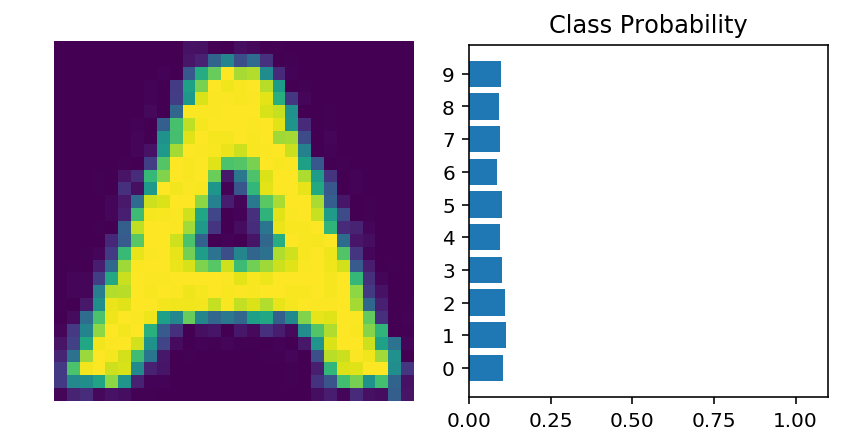

In [8]:
# Probemos la red!

model.eval()

dataiter = iter(testloader)
images, labels = dataiter.next()
images.resize_(images.shape[0], 1, 784)
img = images[0]
# Aplanamos la imagenes
img = img.view(1, 784)

# Estimamos para  cada imagen la probabilidad de pertenencia a una clase (softmax)
with torch.no_grad():
    output = model.forward(img)

ps = torch.exp(output)

# Graficamos
helper.view_classify(img.view(1, 28, 28), ps)